## Classifying Dogs from Forest Images using DuckDuckGo

This code snippet demonstrates how to classify dog images from forest images by leveraging the DuckDuckGo search engine as the data source.

Start by importing the necessary libraries. In this case, we will be using the fastai library for image classification.




In [1]:
import requests

try:
    response = requests.get("https://www.google.com")
    print("Internet access is available.")
except requests.exceptions.RequestException as ex:
    print("No internet access. Check your settings or network connectivity.")


Internet access is available.


In [ ]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

In [ ]:
!pip install fastai

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.

In [3]:
urls = search_images('dog photos', max_images=1)
urls[0]

Searching for 'dog photos'


C:\Users\w2\AppData\Roaming\Python\Python310\site-packages\duckduckgo_search\compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
C:\Users\w2\AppData\Roaming\Python\Python310\site-packages\duckduckgo_search\compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
C:\Users\w2\AppData\Roaming\Python\Python310\site-packages\duckduckgo_search\compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'https://static.businessinsider.com/image/5484d9d1eab8ea3017b17e29/image.jpg'

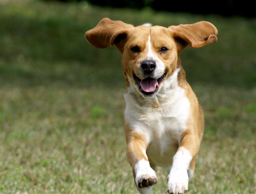

In [4]:
from fastdownload import download_url
dest = 'dog.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'forest photos'


C:\Users\w2\AppData\Roaming\Python\Python310\site-packages\duckduckgo_search\compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
C:\Users\w2\AppData\Roaming\Python\Python310\site-packages\duckduckgo_search\compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
C:\Users\w2\AppData\Roaming\Python\Python310\site-packages\duckduckgo_search\compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


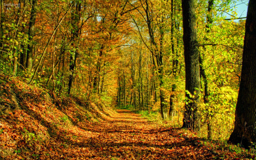

In [5]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "dog" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [6]:
searches = 'forest','dog'
path = Path('dog_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'dog photo'
Searching for 'dog sun photo'
Searching for 'dog shade photo'


Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

To train a model, we'll need DataLoaders, which is an object that contains a training and a validation sets

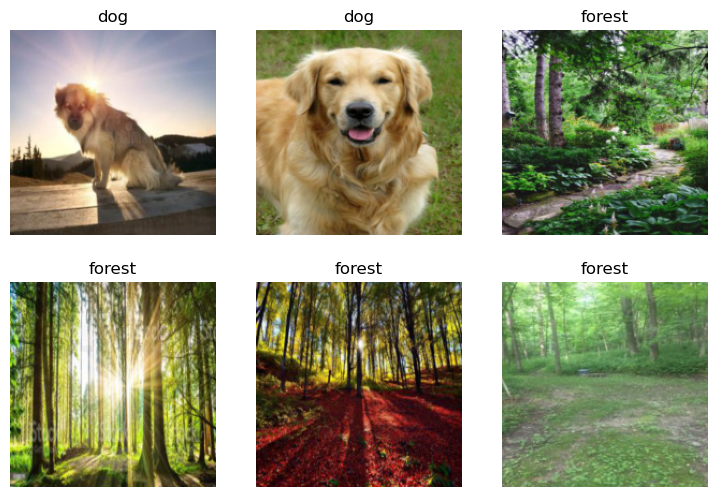

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

C:\ProgramData\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\w2/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:10<00:00, 4.48MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.996204,1.660695,0.441176,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.071138,0.312383,0.088235,00:06
1,0.038722,0.082775,0.029412,00:05
2,0.025922,0.051643,0.029412,00:06


Let's see what our model thinks about that bird we downloaded at the start:

In [21]:
from PIL import Image
is_dog_, probs = learn.predict(PILImage.create('dog.jpg'))
print(f"This is a {is_dog}.")
print(f"Probability it's a dog: {probs[0]:.4f}")

ValueError: too many values to unpack (expected 2)

In [17]:
result = learn.predict(PILImage.create('dog.jpg'))
is_dog_ = result[0]  # Assuming the first value is the prediction
probs = result[1:]  # Assuming the remaining values are probabilities

print(f"This is a: {is_dog_}.")
print(f"Probability it's a dog: {probs[0]:.4f}")


This is a: dog.
Probability it's a dog: 0.0000
